<a href="https://colab.research.google.com/github/jshogland/SpatialModelingTutorials/blob/main/Notebooks/kernel_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estimating kernel weights using PCA and creating optimal predictor surfaces
## In this notebook we will explore the use of Raster Tools and Scikit learn functions to project predictor surfaces into orthogonal space for modeling purposes. A few key objectives of using this approach:
- Determine and use the optimal cell weights of a convolution kernel (user defined size) that can be used to transform a given image and its bands into a subset of surfaces that explain a user specified amount of the variation in the image data.
- Efficiently create orthogonal predictor surfaces that account for band and spatial covariation.
- Create predictor surfaces that highlight various attributes within the data.
### The approach
- Use sampling to create training sets
- Scale input rasters to unit variance
- Perform PCA on scaled training sets that include all input cell values for the cells within a user specified convolution kernel
- Center scaled kernel cell values, multiply PCA score weights by centered values, and sum values within the kernel to perform the convolution
- Optionally, rescale PCA transformed values to a specified bit depth for storage and downstream analyses

John Hogland 12/6/20024

#### Study area for this example includes portions of the Custer Gallatin Nation Forest

Install packages

In [1]:
!pip install mapclassify
!pip install osmnx
!pip install raster_tools
!pip install planetary-computer
!pip install pystac-client
!pip install stackstac

Import libraries

In [2]:
import numpy as np, os, geopandas as gpd, pandas as pd, osmnx as ox, pystac, pystac_client, planetary_computer, stackstac
from shapely import geometry
from raster_tools import Raster, general, Vector, clipping, zonal
from raster_tools import raster
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA


c:\Users\jshogland\AppData\Local\miniconda3\envs\rstools\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Introduction
### Multispectral remotely sensed datasets are commonly used as predictor variables in many classification, regression, and clustering models. Often the data stored within these datasets are not independent and covary across bands and x and y space. For compression, storage, and predictive modeling purposes it is often advantageous to project those data along shared axes of covariance, in turn removing redundancies and creating independent transformed variables. One common technique used to project data along shared covariance is a principal component analysis (PCA). 
### PCAs have successfully been used in many remote sensing projects to mitigate covariance across band space and even reduce the dimensionality of the data for multiple remote sensing projects. However, contemporary remote sensing projects go beyond just the band values acquired at a given location within an image (the cell) and include neighboring cell values to aid in defining textural aspects of an image for a specific region around a location (kernel). Defining and using kernels to enhance, smooth, and or define edge have provided key insights to identifying shapes, boundaries, and various textural attributes contained within an image. However, like multispectral band cell values, texture can also covary across bands. Additionally, the total number of potentially kernels that can be defined and used to quantify texture are infinite.
### This has led some who believe texture to be an import predictive variable for modeling to a priori define kernels known to capture specific textural relationships and apply those kernels across remotely sensed data to develop additional modeling predictor variables. Yet other have taken more of a pragmatic approach and have used iteration and deep learning to define kernel weights that relate to some know value trying to be modeled. However, few, if any remote sensing project have addressed the issues of covariance in neighboring cell values across image bands, nor have the leveraged PCA to define those kernel weights.
### In this example we explore the use of a PCA to project multispectral imagery along shared covariance axes composed of both band and neighboring cell values. Our procedure automates the selection of optimal kernel weights for multidimensional convolution kernels that can be used to project an image into orthogonal laten space while maintaining a predefined proportion of the variation (information) within the underlying data. The spatial extent of our study includes portions of the Custer Gallatin National Forest located in southeastern Montana, USA (Figure 1). 
 

#### Get the boundary data for portions of the Custer Gallatin National Forest and create a interactive location map of the study (Figure 1).

In [3]:
#use OpenStreetMaps to get the boundary of the NF
nf=ox.geocode_to_gdf('Custer Gallatin National Forest, MT, USA')

#get first polygon of the NF
nfe=nf.explode()
nf1=gpd.GeoSeries(nfe.geometry.iloc[10],crs=nf.crs)

#project to Albers equal area
nf1p=nf1.to_crs(5070)

#Visualize the nf1 and sample locations
m=nf1p.explore()
m

C:\Users\jshogland\AppData\Local\Temp\ipykernel_12112\284851902.py:5: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  nfe=nf.explode()


__Figure 1.__ Interactive location map of the study area.

## Methods
### To project Landsat 8 imagery to independent component surfaces (ICSs) we will implement a multistep approach. In step one we will download part of a Landsat scene for the area around the Custer Gallatin Nation Forest (Figure 1) from Planetary Computer. For step two we will create a series of function to extract the values from a systematic random sample of cell location within the Landsat image and surrounding kernel cell values. In step 3 we will flatten kernel cell values by band for each sampled location and perform a principal component analysis. Step 4 will then extract component scores for components that account for 95% of the variation in the data. Finally, we will apply component scores to kernel cell values within each Landsat band. To perform these steps, we will create a series of python functions that utilize Scikit Learn and Raster Tools application programming interface (API). The following relevant functions can be found within the following section/function bulleted list:
- Get Landsat 8 Imagery
    - Create download definition
        - Mosaic_stac
        - Get_stac_data
    - Download the data
- Visualize the boundary and imagery
- Convolution PCA
    - Create Definitions to perform convolution PCA
        - _conv_pca
        - _expand_for_kernel
        - _sys_sample_image
        - conv_pca
    - Perform pca convolution analysis


### Get Landsat 8 Imagery
Create download definitions

In [4]:
#create definition to mosaic stac data
def mosaic_stac(xr):
    return stackstac.mosaic(xr)

#create definition to extract stac data
def get_stac_data(geo,url="https://planetarycomputer.microsoft.com/api/stac/v1",name="sentinel-2-l2a",res=30,crs=5070,**kwarg):
    '''
    gets tiled data from planetary computer as a dask backed xarray that intersects the geometry of the point, line, or polygon

    geo = (polygon) geometry bounding box (WGS84)
    url = (string) base url to planetary computer https://planetarycomputer.microsoft.com/api/stac/v1
    name = (string) catelog resource
    qry =  (dictoinary) of property values {'eo:cloud_cover':{'lt':1}}
    res = (tuple of numbers) output resolution (x,y)
    crs = (int) output crs
    dt = (string) data time intervale e.g., one month: 2023-06, range: 2023-06-02/2023-06-17
    limit = (int) max number of items to return

    returns (xarray data array and stac item catalog)
    '''
    catalog = pystac_client.Client.open(url, modifier=planetary_computer.sign_inplace)
    srch = catalog.search(collections=name, intersects=geo, **kwarg)
    ic = srch.item_collection()
    if(len(ic.items)>0):
        xra = stackstac.stack(ic,resolution=res,epsg=crs)
        xra = mosaic_stac(xra)
    else:
        xra=None

    return xra,ic


Download the data and create a raster object

In [5]:
#get stac data landsat data
if(not os.path.exists('ls82016.tif')):
    xmin,ymin,xmax,ymax=nf1p.buffer(200).total_bounds
    ls30, ic =get_stac_data(nf1.geometry[0],"https://planetarycomputer.microsoft.com/api/stac/v1",name="landsat-c2-l2",res=30,crs=5070,datetime='2016-06-15/2016-06-30',query={'eo:cloud_cover':{'lt':10},'platform':{'eq':'landsat-8'}},limit=1000)
    ls30s=Raster(ls30.sel(band=['red', 'green', 'blue','nir08', 'lwir11','swir16', 'swir22'],x=slice(xmin,xmax),y=slice(ymax,ymin)))
    ls30s=ls30s.save('ls82016.tif')

ls30s=Raster('ls82016.tif')

### Visualize the boundary and  imagery

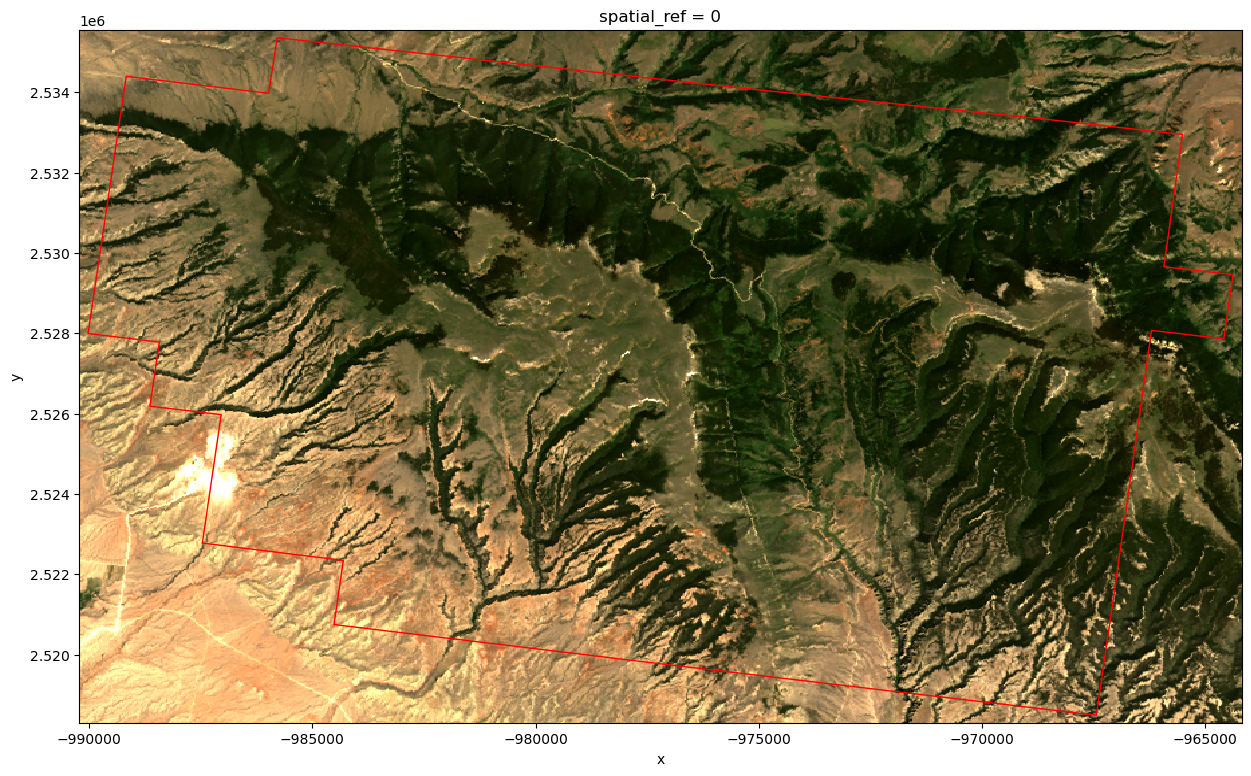

In [6]:
p=nf1p.plot(edgecolor='red',facecolor='none',figsize=(15,9))
p=ls30s.get_bands([1,2,3]).xdata.plot.imshow(ax=p,robust=True)

p

__Figure 2.__ Overlay of Landsat 8 image subset (RGB bands) and the study area boundary outline in red.

### Perform convolution PCA
Create definitions to sample the data, generate weights, and perform convolution analysis.

In [7]:
from raster_tools import creation,focal
from sklearn.preprocessing import MinMaxScaler
import numba as nb

@nb.jit(nopython=True, nogil=True)
def _conv_pca(x,cmp_, m_, size):
    '''
    Performs the convolution given a array, component scores, means, and kernel size using dask's map_overlap function
    x=(numpy array) of data
    cmp_= (numpy array) component scores from sklearn PCA procedure
    m_= (numpy array) mean values from sklearn PCA procedure
    size= (int) width of the kernel

    returns a numpy array of correct shape for PCA transformation
    '''
    bnd,rws,clms=x.shape
    hs=int(size/2)
    outarr=np.empty((cmp_.shape[0],rws,clms))
    for ri in range(hs,rws-hs):
        sr=ri-hs
        for ci in range(hs,clms-hs):
            sc=ci-hs
            vls=x[:,sr:sr+size,sc:sc+size].flatten()
            for b in range(cmp_.shape[0]):
                vls2=((vls-m_)*cmp_[b,:]).sum() #remove the centering piece in standard scaler it is done here
                outarr[b,ri,ci]=vls2

    return outarr

@nb.jit(nopython=True, nogil=True)
def _expand_for_kernel(isys,isxs,wsize):#,mr,mc):
    '''
    Extracts values for kernel cells. Cells indices falling on the boundary of the image are moved in one index value.
    isys=array of row index locations
    isxs=array of column index locations
    wsize=width of the kernel
    mr=max row index
    mc=max column index

    returns two new lists of index values that can be used to extract coordinate from an xarray data array
    '''
    hw=int(wsize/2)
    isys2=np.zeros(isys.shape[0]*wsize,dtype='int32')
    isxs2=np.zeros(isxs.shape[0]*wsize,dtype='int32')
    for r in range(isys.shape[0]):
        cvl=isys[r]
        cvlm=cvl-hw
        for r2 in range(wsize):
            nr=r2+r*wsize
            nvl=cvlm+r2
            # if(nvl>=mr):
            #     nvl=mr-1

            isys2[nr]=nvl

    for c in range(isxs.shape[0]):
        cvl=isxs[c]
        cvlm=cvl-hw
        for c2 in range(wsize):
            nc=c2+c*wsize
            nvl=cvlm+c2
            # if(nvl>=mc):
            #     nvl=mc-1

            isxs2[nc]=nvl

    return isys2,isxs2

def _sys_sample_image(rs,p,wsize=0):
    '''
    Creates a systematic sample of an image given a percent of cells sampled.
    rs = Raster object to be sampled
    p = percent of pixels to sample
    wsize=(int) width of a square kernel in cells if using convolution type analyses

    returns a 2d array of cell values rows=point centroid columns= band values
    if using kernels columns correspond to kernel cell values for each point
    '''
    bnds,rws,clms=rs.shape
    ys=rs.y
    xs=rs.x
    psq=np.sqrt(p)
    sr=int(rws/(rws*psq))
    sc=int(clms/(clms*psq))
    rstr=int(np.random.rand()*sr)
    rstc=int(np.random.rand()*sc)
    isys=np.arange(rstr+wsize,rws-wsize,sr)
    isxs=np.arange(rstc+wsize,clms-wsize,sc)
    rws2=isys.shape[0]
    clms2=isxs.shape[0]
    if(wsize>0):
        bnds=bnds*wsize**2
        isys,isxs=_expand_for_kernel(isys,isxs,wsize)#,rws,clms)

    sys=ys[isys]
    sxs=xs[isxs]
    sel=rs.xdata.sel(x=sxs,y=sys)
    # lx,ly=np.meshgrid(sel.x,sel.y) #if you want to look at the location of each sampled cell
    # pnts=gpd.GeoSeries(gpd.points_from_xy(x=lx.flatten(),y=ly.flatten(),crs=rs.crs))
    vls=np.moveaxis(sel.values,0,-1).flatten().reshape((rws2*clms2,bnds))

    return vls#, pnts, sel

def conv_pca(rs,prc=0.9,smp=0.01,ksize=0,output_bit_depth=None):
    '''
    determines convolution kernel weights for an optimal raster projection and returns a transformed raster
    using those weights. Weights are derived from a PCA analysis of each kernel cell value. Kernel cell
    values are extracted for each band in the rs stack.

    rs=(Raster) input raster object
    wsize=(int) window diameter for a square kernel measured in cells
    prc=(float) the proportion of variation in the data kept in the final raster dataset (0-1)
    smp=(float) the proportion of data used to build the transformation (training data - systematic random sample of location)
    ksize=(int) kernel width to use measured in cells
    output_bit_depths=(int) optional parameter used to scale the analysis outputs to a specified bit depth (e.g., 8,16,32).
    By default (None) output values will not be scaled

    returns a projected raster object and the pca object
    '''
    #scale values using a sample
    vls=_sys_sample_image(rs,p=smp)
    ss=StandardScaler(with_mean=False)
    ss.fit(vls)

    #apply the scaling to the input raster
    ss_mdl = general.ModelPredictAdaptor(ss,'transform')
    nch=(rs.nbands,*rs.xdata.chunks[1:])
    sc_pred_rs=rs.model_predict(ss_mdl,rs.nbands).chunk(nch)

    #perform pca using a sample of the scaled raster values
    vls2=_sys_sample_image(sc_pred_rs,p=smp,wsize=ksize)
    pca=PCA()
    pca.fit(vls2)
    #determine number of components to use
    ev=pca.explained_variance_ratio_
    sev=0
    for i in range(ev.shape[0]):
        e=ev[i]
        sev+=e
        if sev>prc:
            break
    kc=i+1 #add one to address 0 start

    #extract component scores for _conv_pca method
    kdf=pca.components_[0:kc,:] #scores,component (rows have weightings)
    hw=int(ksize/2)

    #apply _conv_pca to map_overlap function
    darr=sc_pred_rs.data.map_overlap(
        _conv_pca,
        depth={0: 0, 1: hw, 2: hw},
        chunks=((kdf.shape[0],),*sc_pred_rs.data.chunks[1:]),
        boundary=np.nan,
        dtype='f8',
        meta=np.array((),dtype='f8'),
        cmp_=kdf,
        m_=pca.mean_,
        size=ksize
    )
    #convert dask array back to a raster
    cmp_rs=raster.data_to_raster(darr,x=sc_pred_rs.x,y=sc_pred_rs.y,affine=sc_pred_rs.affine,crs=sc_pred_rs.crs,nv=sc_pred_rs.null_value)

    #scale projected raster to bit depth if specified
    if(not output_bit_depth is None):
        pcasvls=pca.transform(vls2)[:,0:kc]
        mmsc=MinMaxScaler()
        mmsc.fit(pcasvls)
        mmsc_mdl=general.ModelPredictAdaptor(mmsc,'transform')
        cmp_rs=(cmp_rs.model_predict(mmsc_mdl,cmp_rs.nbands)*(2**output_bit_depth-1)).astype('uint'+str(output_bit_depth))

    return cmp_rs,pca



Perform the PCA convolution process

In [8]:
#perform the pca convolution process on the landsat image; kernel size 5 by 5, output bit depth 16.
# This can be any size kernel. I have tried up to a 15 by 15.
ksize=5
conv_rs,pca=conv_pca(ls30s,prc=0.95,smp=0.1,ksize=ksize,output_bit_depth=16)

c:\Users\jshogland\AppData\Local\miniconda3\envs\rstools\lib\site-packages\raster_tools\raster.py:1689: UserWarning: The null value -999999.0 could not be cast to uint16. It has been automatically changed to 9999
  nv = reconcile_nullvalue_with_dtype(


## Results
### Using our described approach, we were able to account for 95% of the variation with the Landsat 8 image, for convolution kernels of size five by five cells, using the first eleven principal components (Figure 3). Component convolution kernel weights (Display 1) highlight the linear relationships among both Landsat image bands and neighboring kernel cell values. For a random systematic sample of approximately 10% of the first 3 component values, five unique clusters of information with varying trends appear in component space (Figure 4). 
### To transform our Landsat 8 image into 11 ICSs (Figure 5), required processing 77 total 5 by 5 convolution kernels. To explain the remaining 5% of the variation in the data, an additional 1148 convolution kernels would need to be processed. Using a threshold of 95% of the variation within the data substantially reduces the total amount of processing need to create ICSs while simultaneously keeping the vast majority of information within the data. Moreover, implementing this processing within the Raster Tools processing architecture was easy and extremely efficient.
### Visually, each ICS highlights a different aspect of the Landsat imagery that has been processed with a five by five convolution kernel (Figure 5). Within each ICS, linear combinations of both hue and texture are highlighted to varying degrees and are projected such that each surface is independent, which can be ideal for downstream predictive modeling.
### The following processing steps were used to create Figures 3-5 and Display 1.
- Visualize % variation
- Look at kernel weights
- Look at 3d plot
- Visualize the PCA convolution raster surfaces


### - Visualize % variation explained in each band (component) of the transformed image (Figure 3).
#### The number of bands correspond to the number of components that account for 95% of the variation in the 5 by 5 convolved image. Note that most of the variation/information in the data is explained in the first 3 components

None

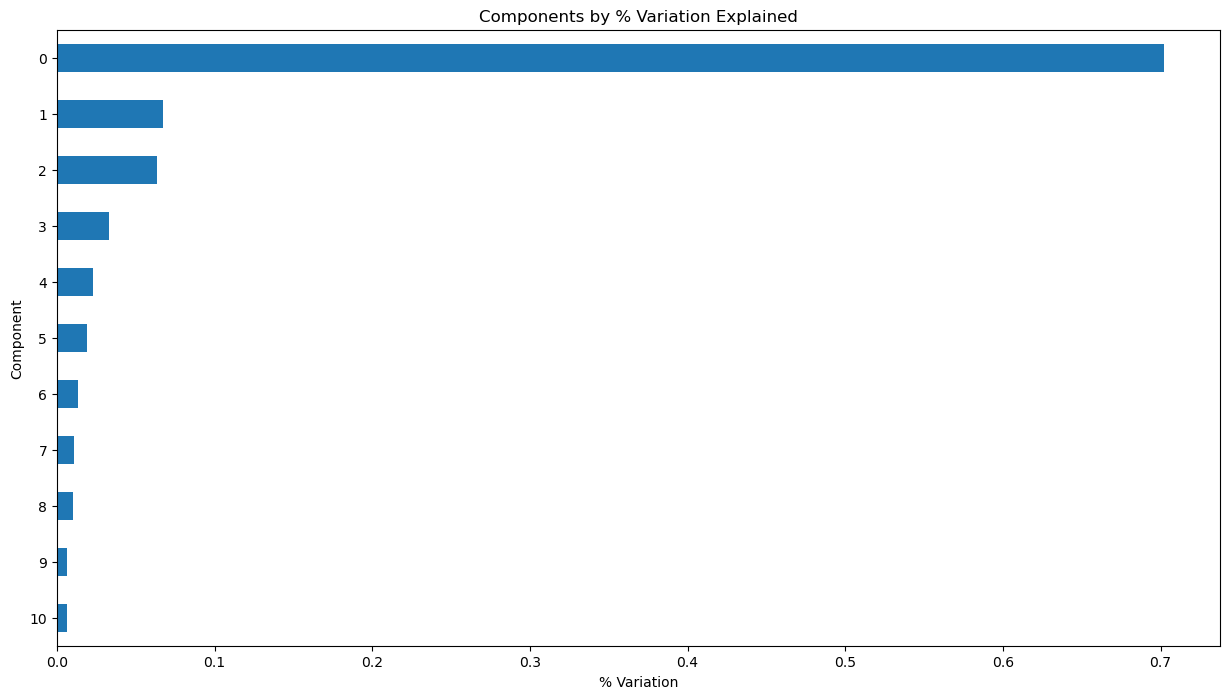

In [9]:
var_exp=pd.DataFrame(pca.explained_variance_ratio_[:conv_rs.nbands])
p=var_exp.plot(kind='barh',title='Components by % Variation Explained', xlabel='% Variation', ylabel='Component', figsize=(15,8),legend=False).invert_yaxis()
display(p)

__Figure 3.__ Proportion of variation explained in each principal component. 

### - Look at the kernel weights for each selected component (Display 1).
#### Each component is made of the summation of 7 convolution kernels with the following weights. Convolution weights are applied to the centered and scaled input surface values of each band within the specified kernel of the input raster surface (ls30s in our example).

In [11]:
kw=pca.components_[0:conv_rs.nbands,:]
for k in range(kw.shape[0]):
    krs=kw[k].reshape((ls30s.nbands,ksize,ksize))
    print('\nWeights for component',k)
    print(krs)


Weights for component 0
[[[0.07565114 0.07442686 0.07474631 0.03459577 0.07742166]
  [0.07353432 0.07588807 0.07716725 0.07604243 0.07636951]
  [0.03623809 0.0783325  0.07530005 0.0774492  0.07839988]
  [0.07738671 0.07759166 0.03767341 0.07924538 0.07690967]
  [0.07884034 0.07970899 0.07879729 0.07894729 0.03932939]]

 [[0.08004381 0.07847125 0.08020966 0.08032591 0.07949108]
  [0.0796687  0.04018198 0.08070396 0.07934367 0.08093664]
  [0.08029168 0.07937984 0.07952889 0.03961641 0.08054878]
  [0.07897297 0.08077336 0.08093851 0.08010678 0.08027532]
  [0.04051053 0.08120991 0.07987461 0.08152622 0.08135573]]

 [[0.0805652  0.0807098  0.04122659 0.08176185 0.08057601]
  [0.08208752 0.08174183 0.0810367  0.08110733 0.04200869]
  [0.08214261 0.08108791 0.08253607 0.08199661 0.08135725]
  [0.08146175 0.04256328 0.08232196 0.08140968 0.0827853 ]
  [0.08212731 0.08142336 0.08149599 0.04218155 0.08243562]]

 [[0.08140657 0.08290073 0.08238709 0.08174846 0.08185244]
  [0.04276488 0.08261734 

__Display 1.__ Kernel weights for each component of the PCA convolution.

### - Look at a 3d plot of the first 3 components for systematic random locations using 10% of the data. (Figure 4)

In [195]:
import plotly.express as px
#get a sample of the PCA convolution raster values
vls=_sys_sample_image(conv_rs,0.1,1) #convolve 1 to remove convolved image edge effect in sampling 
df=pd.DataFrame(vls)
fig = px.scatter_3d(df, x=0, y=1, z=2
              ,width=1500,height=800)

fig.show()


__Figure 4.__ A 3 dimensional representation of the first 3 principal components scores values for ~10% of the cell locations within the Landsat 8 image. 

### - Visualize the PCA convolution raster surfaces (Figure 5)

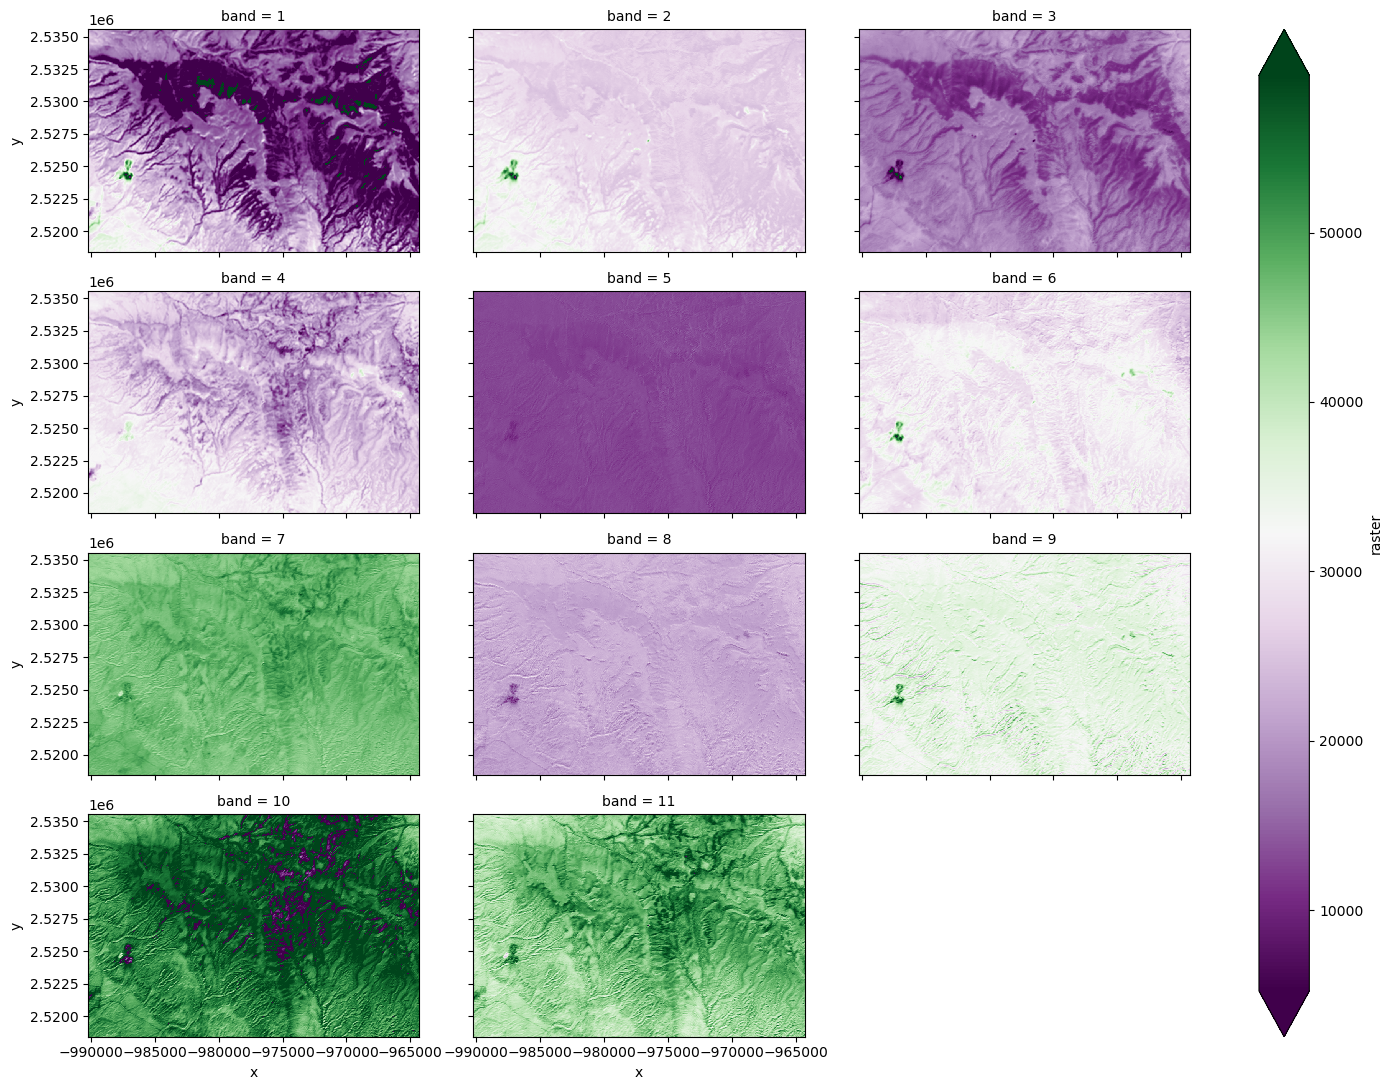

In [13]:
conv_rs.plot(x='x',y='y',col='band',col_wrap=3,figsize=(15,conv_rs.nbands),robust=True,cmap='PRGn')

__Figure 5.__ Independent component surfaces (ICSs) derived from a principal component analysis of values taken from a systematic sample of cell locations within a subset of a Landsat scene for a kernel size of five by five cells. The first eleven ICSs account for a more than 95% of the variance within the data.    

## Discussion
### In this notebook we have demonstrated how to use sampling, convolution kernels, and PCA to project multi-band raster data into independent component space (Figure 4) that highlights various orthogonal aspects of the input data while simultaneously reducing the dimensionality of the data. The results of our analysis emphasize both hue and textural aspects of the data within each principal component that can also be viewed as a series of convolution kernel weights. While kernel cell weights provide unique insights into the linear relationships among image bands and neighbor cell values, combined with Raster Tools processing architecture they can be used to produce independent component raster surfaces (ICSs, Figure 5), that spatially emphasize independent hue and textural aspects of the input data. 
### For example, the first ICS in Figure 5 highlights a hue change across spectral bands that emphasizes bright to dark cell values within the image. The kernel weights for the first component (Display 1) verify this assertion with all positive values that generally share importance equally across all band kernels and cell values. When compared against second component ICS (Figure 5), it is clear that this component emphasizes the differences between color and infrared band values while also highlighting an edge effect of neighboring pixel values (Display 1). Investigating the weights of each kernel, for each component, can provide insights regarding the relative amounts of information (variation) within the data across both raster bands and neighboring cell space. 

### Additionally, projecting band and neighboring cell values into orthogonal space provides a straightforward way to maintains as much information as possible within the data while simultaneously reducing the duplicated aspects of the data (Figure 3). In our example we ordered each component based on the amount of variation explained in the data for that component and used a threshold of 95% of the total variation in the data to determine the number of ICSs to create. Depending on the question at hand, analyst may want to pick and choose which components have relevance to the phenomenon of interest. Once decided and projected, ICSs surfaces can be used as inputs to further downstream analyses as potential predictor variables and/or kernel weights could be used as potential kernel cell starting values in deep learning convolution neural networks to aid in solving for optimal kernel cell weights given a set of labels. 

### Although the objective in this example was to linear project the raster data across both image bands and neighboring cell values in a way that reduces the dimensionality of the data and determine a set of kernel weights used to produce ICSs, one could easily apply this same type of approach to optimize kernel cell weights for regression and classification. The primary difference in this case being that a regression or classification methodology along with training response values would be used to optimally determine kernel cell weights as opposed to using a PCA to determine kernel cell values. It is also worth noting that in the case of optimizing kernel cell weights for regression or classification, ICSs surface could be inputs to the process. Regardless of intended use, our described approach provides an optimal solution that linearly describes unique hue and textural aspects of the data across both raster band channels and neighboring cell values while simultaneously reducing the dimensionality of the data, making it ideal for downstream regression and classification analysis.                             

## Conclusion
### This approach to estimating weights for each convolution kernel and then further using those weights to convolve an image (raster stack) appears to do a good job of highlighting various features in the image, is quick, and mathematically determines kernel weights such that each band in the output convolved image is independent of the other bands values. Moreover, the process removes all redundant information across band's and within kernel cell values, which is also desirable. These surfaces should make for good predictor variables and should make it easy to spread and balance a sample across all the information in a convolved image.  